# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [73]:
%matplotlib inline

import os
import sys 
import json
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph
from datetime import date
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby, chain
from copy import deepcopy 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.utils.timez import epochptime

In [74]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures")
# RESULTS  = os.path.join(FIXTURES, 'test-raft-single.json')
# RESULTS  = os.path.join(FIXTURES, 'test-eventual-single.json')
RESULTS  = os.path.join(FIXTURES, "results", 'test-tags-single.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

In [75]:
def title(text):
    return " ".join([t.capitalize() for t in text.split("_")])

def report(data, title=None, total=None, sort=True):
    """
    Expects data to be a list of (name, value) pairs.
    Total will be computed from data or accepted if passed in.
    Title will be the header for the report. 
    """
    if total is None:
        total = sum(val[1] for val in data)
    
    if title is None:
        title = "Key/Val Report"
    
    if sort:
        data = sorted(data, key=itemgetter(0))
    
    # Banner length and max key length
    blen = len(title)
    klen = max([max([len(val[0]) for val in data]), len('total')])
    fmtr = "{{: <{}}} {{: >{}}}".format(klen, blen-klen-1)
    
    output = [title, "="*blen]
    
    for key, val in data:
        output.append(fmtr.format(key, val))
                
    output.append("-"*blen)
    output.append(fmtr.format('total', total))
    return "\n".join(output)

def report_details():
    banner = (
        "Simulation: {} (Cloudscope v{})\n"
        "{}\n\n"
        "Ran on: {} ({})\n\n"
        "Settings\n"
        "========\n"
    ).format(
        data['simulation'], data['version'], data['topology']['meta']['description'],
        epochptime(data['timer']['started']).strftime('%b %d, %Y at %H:%M %Z'), 
        data['timer']['elapsed'],
        data['randseed'],
    )
    
    longest = max(len(key) for key in data['settings'])
    frmt = "{{: <{0}}} {{: >12}}".format(longest)
    
    
    return banner + "\n".join([
        frmt.format(title(key), value)
        for key, value in data['settings'].items()
    ])
    

def report_topology():
    topology = deepcopy(data['topology'])
    nodes = topology['nodes']
    links = topology['links']
    
    for link in links:
        latency = [link['latency']] if link['connection'] == 'constant' else link['latency']
        
        for rid in ('source', 'target'):
            node = nodes[link[rid]]
            
            if 'minlat' not in node:
                node['minlat'] = latency[0]
            else:
                
                node['minlat'] = min(node['minlat'], latency[0])

            if 'maxlat' not in node:
                node['maxlat'] = latency[-1]
            else:
                node['maxlat'] = max(node['maxlat'], latency[-1])
         
    output = []
    for node in sorted(nodes, key=itemgetter('id')):
        output.append(
            "{}: {} ({}, {}) {}-{}ms connection".format(
                node['id'], node['label'], node['location'], node['consistency'], node['minlat'], node['maxlat']
            )
        )
    return "\n".join(output)

In [76]:
def report_reads_writes():
    counts = defaultdict(Counter)
    totals = Counter()
    for access in ('read', 'write'):
        for (rid, loc, ts) in data['results'].get(access, []):
            counts[rid][access] += 1
            totals[access] += 1
    
    total = "{}/{}".format(totals['read'], totals['write'])
    
    return report([
            (rid, "{}/{}".format(c['read'], c['write']))
            for rid, c in counts.items()
        ], "Accesses (read/write)", total=total)

In [77]:
def report_stale_reads():
    stale = data['results'].get('stale reads', [])
    if not stale:
        return "No Stale Reads"
    
    stale.sort(key=itemgetter(0))
    
    return report([
            (rid, sum(1 for v in values))
            for rid, values in groupby(stale, itemgetter(0))
        ], "Stale Reads")

In [78]:
def report_visibility_latencies():
    visibilities = data['results'].get('visibility latency', [])
    if not visibilities:
        return "No visibility latency metrics" 
    
    latencies = defaultdict(list)
    versions  = set([])
    
    for writer, vid, start, finish in visibilities:
        latencies[writer].append(finish - start)
        versions.add(vid)
    
    total  = sum(l for l in chain(*latencies.values())) / sum(1 for l in chain(*latencies.values()))
    total  = "{:0.4f} secs".format(total / 1000)

    header =  (
        "Fully visible writes:{: >6}\n"
        "Total number of writes:{: >4}\n\n"
    ).format(len(versions), len(data['results']['write']))
    
    return header + report([
        (rid, "{:0.4f} secs".format((sum(l) / len(l)) / 1000))
        for rid, l in latencies.items()
    ], 'Mean Visibility Latency', total=total)

In [79]:
def draw_topology():
    cmap = {
        'strong': '#91cf60',
        'medium': '#ffffbf',
        'low': '#fc8d59',
    }
    
    lmap = {
        'constant': 'solid',
        'variable': 'dashed',
    }

    G = json_graph.node_link_graph(data['topology'])
    colors = [cmap[n[1]['consistency']] for n in G.nodes(data=True)]
    links  = [lmap[n[2]['connection']] for n in G.edges(data=True)]
    nx.draw_circular(G, with_labels=True, node_size=800, node_color=colors, font_weight='bold', style=links, edge_color='#333333')

In [80]:
def create_dataframe():
    table = []
    meta  = data['topology']['meta']
    conf  = data['settings']

    results = data['results']
    item    = {'rid': "e{:0>2}".format(0)}
    item['variable (ms)'] = meta['variable']

    # Variable latency 
    latency = meta['variable'].rstrip('ms').strip().split('-')
    latency = sum(map(float, [ms for ms in latency if ms != 'N/A'])) / 2

    # Constant latency 
    if not latency:
        latency = float(meta['constant'].rstrip('ms').strip())

    item['mean latency (ms)'] = latency
    item['constant (ms)'] = meta['constant']
    item['users'] = conf['users']
    item['anti-entropy delay (ms)'] = conf['anti_entropy_delay']
    for key, values in results.iteritems():
        if key == 'visibility latency':
            item['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
            item['visible writes'] = len(set([v[1] for v in values]))
        if key == 'commit latency':
            item['commit latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
            item['committed writes'] = len(set([v[1] for v in values]))
        else:
            item[key] = len(values)

    item['ratio fully visible to writes'] = float(item.get('visible writes', 0)) / float(item['write'])

    table.append(item)
    
    return pd.DataFrame(table)

df = create_dataframe()

In [89]:
def create_dataframe():
    
    # Handlers for various rows: return a dictionary to add to data frame. 
    def default_handler(key, values):
        return {
            key: len(values) 
        }
    
    def handle_visibility_latency(key, values):
        return {
            "visibility latency (ms)": sum(v[2] - v[1] for v in values) / len(values), 
            "visible writes": len(set([v[1] for v in values]))
        }
    
    def handle_commit_latency(key, values):
        return {
            "commit latency (ms)": sum(v[2] - v[1] for v in values) / len(values),
            "committed writes": len(set([v[1] for v in values]))
        }

    def handle_session_length(key, values):
        return {
            "sessions": len(values), 
            "mean session duration (ms)": sum(v[0] for v in values) / len(values),
        }

    def handle_read_latency(key, values):
        return {
            "completed reads": len(values), 
            "mean read latency (ms)": sum(v[0] for v in values) / len(values),
        }
    
    def handle_tag_size(key, values):
        return {
            "average tag size": sum(v[1] for v in values) / len(values)
        }
    
    def rename_key(name, func=default_handler):
        def handle_rename(key, values):
            item = func(key, values)
            return {
                name: item[key]
            }
        return handle_rename
        

    # Handler map 
    handlers = {
        'visibility latency': handle_visibility_latency, 
        'commit latency': handle_commit_latency, 
        'session length': handle_session_length,
        'read latency': handle_read_latency,
        'tag size': handle_tag_size,
        'read': rename_key('reads'),
        'write': rename_key('writes'),
    }
    
    replicas = defaultdict(lambda: defaultdict(list)) 
    topology = data['topology']
    config   = data['settings']
    results  = data['results']
    
    # Extract per-replica ID values from all results series 
    for key, values in results.iteritems():
        for value in values:
            # Some quick checks 
            assert len(value) > 1 
            assert value[0].startswith('r')
            
            # Append the series to the specific replica 
            replicas[value[0]][key].append(value[1:])
    
    # Create a table with each replica id
    table = []
    for replica, results in replicas.iteritems():
        row = {'replica': replica} 
        
        # Perform per-replica aggreations for each result set 
        for result, values in results.iteritems():
            handler = handlers.get(result, default_handler)
            row.update(handler(result, values))
        
        # Add in topology information 
        
        
        table.append(row)
    
    # Create the data frame and compute aggregate dependency items 
    df = pd.DataFrame(sorted(table, key=itemgetter('replica')))
    df['missed reads'] = df['reads'] - df['completed reads']
    df['dropped writes'] = df['writes'] - df ['visible writes']
    df['visibility ratio'] = df['visible writes'] / df['writes']
    
    return df

df = create_dataframe()
df 

,average tag size,completed reads,mean read latency (ms),mean session duration (ms),reads,replica,sessions,visibility latency (ms),visible writes,writes,missed reads,dropped writes,visibility ratio
0,1,77,0,50409.385081,178,r0,34,15,38,98,101,60,0.387755
1,1,56,0,38622.077406,141,r1,32,15,34,78,85,44,0.435897
2,1,70,0,43093.506966,159,r2,41,15,32,68,89,36,0.470588
3,1,59,0,59784.675204,154,r3,29,15,32,76,95,44,0.421053
4,1,52,0,79952.678431,147,r4,31,15,35,73,95,38,0.479452
5,1,68,0,41608.715748,171,r5,34,15,35,87,103,52,0.402299
6,1,72,0,51945.721635,165,r6,37,15,33,76,93,43,0.434211
7,1,82,0,54734.766463,171,r7,36,15,26,70,89,44,0.371429
8,1,67,0,41008.413899,160,r8,31,15,38,75,93,37,0.506667
9,1,56,0,53668.299525,156,r9,34,15,33,87,100,54,0.379310


# Results 

In [82]:
print report_details()

Simulation: Single medium Cluster (Cloudscope v0.3)
Toplogy for single medium cluster experiments.

Ran on: Mar 10, 2016 at 18:03 UTC (1 seconds)

Settings
Default Latency               800
Do Rumoring                     1
Users                           1
Move Prob                     0.2
Anti Entropy Delay            600
Election Timeout       [150, 300]
Object Prob                   0.3
Default Consistency        strong
Valid Locations      [u'home', u'work', u'mobile', u'cloud']
Switch Prob                   0.3
Heartbeat Interval             75
Session Timeout              4096
Access Stddev                 512
Default Replica           storage
Read Prob                    0.68
Random Seed                    42
Invalid Types         [u'backup']
Max Objects Accessed           10
Do Gossip                       1
Max Sim Time              4320000
Access Mean                  1800


## Topology

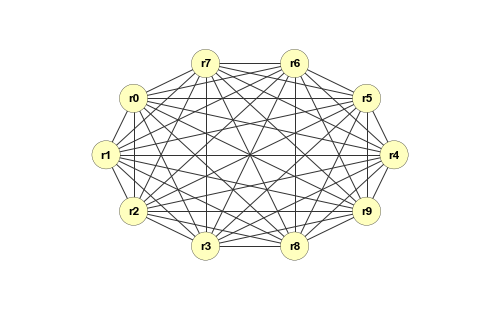

In [83]:
draw_topology()

In [84]:
print report_topology()

r0: Raft 1 (cloud, medium) 15-15ms connection
r1: Raft 2 (cloud, medium) 15-15ms connection
r2: Raft 3 (cloud, medium) 15-15ms connection
r3: Raft 4 (cloud, medium) 15-15ms connection
r4: Raft 5 (cloud, medium) 15-15ms connection
r5: Raft 6 (cloud, medium) 15-15ms connection
r6: Raft 7 (cloud, medium) 15-15ms connection
r7: Raft 8 (cloud, medium) 15-15ms connection
r8: Raft 9 (cloud, medium) 15-15ms connection
r9: Raft 10 (cloud, medium) 15-15ms connection


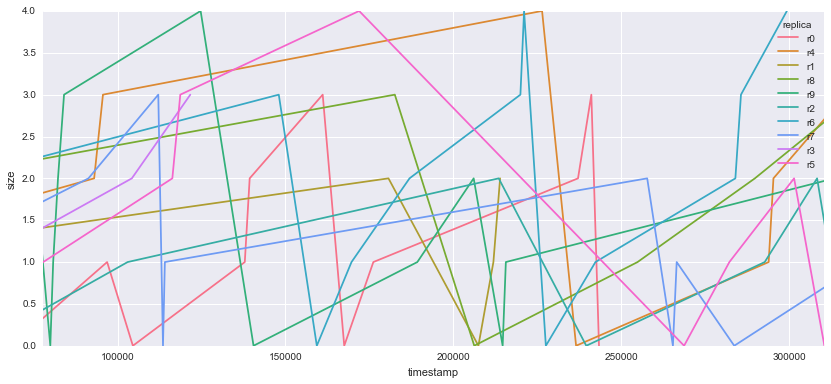

In [111]:
plt.figure(figsize=(14, 6))
tsize = pd.DataFrame(data['results']['tag size'])
tsize.columns = ['replica', 'timestamp', 'size']
sns.tsplot(time="timestamp", value='size', unit='replica', condition='replica', data=tsize.head(100))

## Metrics 

The following metrics are reported from the results.

### Reads and Writes

In [85]:
print report_reads_writes()

Accesses (read/write)
r0             178/98
r1             141/78
r2             159/68
r3             154/76
r4             147/73
r5             171/87
r6             165/76
r7             171/70
r8             160/75
r9             156/87
---------------------
total        1602/788


### Stale Reads

In [86]:
print report_stale_reads()

No Stale Reads


### Visibility Latency 

In [87]:
print report_visibility_latencies()

Fully visible writes:   336
Total number of writes: 788

Mean Visibility Latency
r0          0.0150 secs
r1          0.0150 secs
r2          0.0150 secs
r3          0.0150 secs
r4          0.0150 secs
r5          0.0150 secs
r6          0.0150 secs
r7          0.0150 secs
r8          0.0150 secs
r9          0.0150 secs
-----------------------
total       0.0150 secs
